# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Оглавление

<a id='intro'></a>
[1. Подготовка данных](#task1).

-   [1.1 Изучение общей информации](#task2).
   
-   [1.2 Предобработка данных](#task3).

[2. Обучение моделей](#task4).

[3. Анализ моделей](#task5).

[4. Общий вывод](#task6).

# Цели исследования

Построить модель для предсказания рыночной стоимости своего автомобиля, которую можно будет использовать в приложении сервиса по продаже автомобилей. 

# Описание данных

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:** 
- Price — цена (евро)

# План работы

1. Изучить информацию о данных и подготовить данные;
2. Подготовить выборки для обучения моделей;
3. Обучить разные модели (одна из которых — LightGBM, как минимум одна — не бустинг) с различными сочетаниями гиперпараметров;
4. Проанализировать время обучения, время предсказания и качество моделей;
5. Выбрать лучшую модель по критериям заказчика и проверить её качество на тестовой выборке.

[Оглавление](#intro).
<a id='task1'></a>

## Подготовка данных

[Оглавление](#intro).
<a id='task2'></a>

### Изучение общей информации

**Импортируем необходимые библиотеки вначале документа (pandas, numpy, matplotlib.pyplot и другие).**

In [1]:
import sys
!"{sys.executable}" -m pip install phik

In [2]:
import time
import pandas as pd
import numpy as np

# graph
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

# ML
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

**Считаем данные из csv-файла и сохраним в переменную `data`. Путь к файлу: `/datasets/autos.csv`**

In [3]:
try:
    #data = pd.read_csv('/datasets/autos.csv')
    data = pd.read_csv('C:/Users/User/Desktop/DS Python/Projects/autos.csv')
except:
    data = 'не удалось выгрузить данные!'

**Выведем первые 5 строк датафрейма `data` на экран.**

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Выведем основную информацию о данном датафрейме с помощью метода info().**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Выведем информацию о количестве пропусков по столбцам в данном датафрейме с помощью метода isna() в процентах.**|

In [6]:
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.580000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.560000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.280000


Обнаружены пропуски в таких признаках как: `VehicleType` — тип автомобильного кузова, Gearbox — тип коробки передач, `Model` — модель автомобиля, `FuelType` — тип топлива, `Repaired` — была машина в ремонте или нет. 

Наибольшие и критические пропуски обнаружены в признаке `Repaired` - около **20%** из общего числа данных. 

Все эти признаки категориальные. 

**Проверим, есть ли строки-дубликаты в датасете `data`**

In [7]:
print('Количество дубликатов в датасете data:', data.duplicated().sum())
print(f"Количество дубликатов в процентном соотношении {(data.duplicated().sum() / data.shape[0]) * 100} %.")

Количество дубликатов в датасете data: 4
Количество дубликатов в процентном соотношении 0.0011287669068118262 %.


Количество дубликатов **менее 10%**. Можно удалить данные строки. 

**Вывод:**
1. Импортировали необходимые библиотеки.
2. Считали данные из csv-файла.
3. Вывели общую информацию по датафрейму: 
    - в датафрейме 16 столбцов и 354.369 строк;
    - присутствуют некорректно названные столбцы (не в змеином регистре);
    - в датасете присутствуют пропуски;
    - общая занимаемая память 43.3+ MB.
4. Подготовились к этапу 'Предобработка данных'.

[Оглавление](#intro).
<a id='task3'></a>

### Предобработка данных

**Стиль заголовков сделан в 'верблюжьем' регистре, переведем все в 'змеиный' регистр.**

Напишем функцию перевода:

In [8]:
# функция получает на вход список из наименований, а также задан разделитель
def camel_to_snake(columns, sep='_'): 
    # новый список, который будет формироваться из новых наименований
    columns_new = [] 
    # переберем каждое слово списка
    for column in columns:
        # новое слово в змеином регистре
        snake_register = ''
        # перебираем каждое слово по букве
        for i in column:
            # если встретили символ в верхнем регистре
            if i.isupper(): 
                # добавим разделитель и этот символ в нижнем регистре
                snake_register += sep + i.lower()
            else:
                snake_register += i
        snake_register = snake_register.lstrip(sep)
        # добавим новое слово в новый список 
        columns_new.append(snake_register)
    return columns_new

Переименуем все названия столбцов и выведем 10 первых строк датасета с новыми названиями колонн.

In [9]:
data.columns = camel_to_snake(data.columns)
data.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


**Удалим строки-дубликаты в датасете `data`**

In [10]:
data = data.drop_duplicates(keep='first')
print('Количество дубликатов в датасете data:', data.duplicated().sum())

Количество дубликатов в датасете data: 0


**Признаки `DateCrawled`, `DateCreated`, `NumberOfPictures`,`PostalCode`, `LastSeen` не нужны для предсказания цены автомобиля, построения модели и ее отладки.**

Хотя, теоретически, дата создания анкеты может влиять на цену. Чем дольше анкета висит на сайте, тем меньше вероятности, что ее купят за указанную цену продавцом. (либо автомобиль имеет какие-то существенные недостатки). В любом случае, цена сформирована не совсем точно. 

Также `PostalCode` почтовый индекс тоже в теории может влиять. То есть от города к городу цена на автомобиль может немного меняться. Но если считать, в масштабах страны, то можно сказать, что цена не сильно меняется. Удалим признак, чтобы не перегружать модель.

Так как `model`содержит значения, которые сложно преобразовать в категориальные и для облегчения работы моделей CatBoost и LightGBM удалим его из датасета.

Удалим данные столбцы из таблицы

In [11]:
data = data.drop(columns='model')

In [12]:
data = data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'registration_month'], axis=1)

In [13]:
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,10.580000
registration_year,0.000000
gearbox,5.600000
power,0.000000
kilometer,0.000000
fuel_type,9.280000
brand,0.000000
repaired,20.080000


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   kilometer          354365 non-null  int64 
 6   fuel_type          321470 non-null  object
 7   brand              354365 non-null  object
 8   repaired           283211 non-null  object
dtypes: int64(4), object(5)
memory usage: 27.0+ MB


**Удалим пропуски по столбцам (`vehicle_type`, `gearbox`, `model`, `fuel_type`) в датасете `data`** 

`vehicle_type` — тип автомобильного кузова, `gearbox` — тип коробки передач, `model` — модель автомобиля, `FuelType` — тип топлива

In [15]:
data[['vehicle_type', 'gearbox', 'fuel_type']] = data[['vehicle_type', 'gearbox', 'fuel_type']].fillna('unknown')

**Пропуски в столбце `repaired` (была машина в ремонте или нет) в датасете `data` заполним значением-заглушкой 'na'.**

In [16]:
data = data.fillna('na')

In [17]:
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


**Построим и визуализируем матрицу корреляции признаков чтобы оценить степень скоррелированности признаков.**

In [18]:
phik_overview = data.phik_matrix()
#phik_overview.round(2);

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


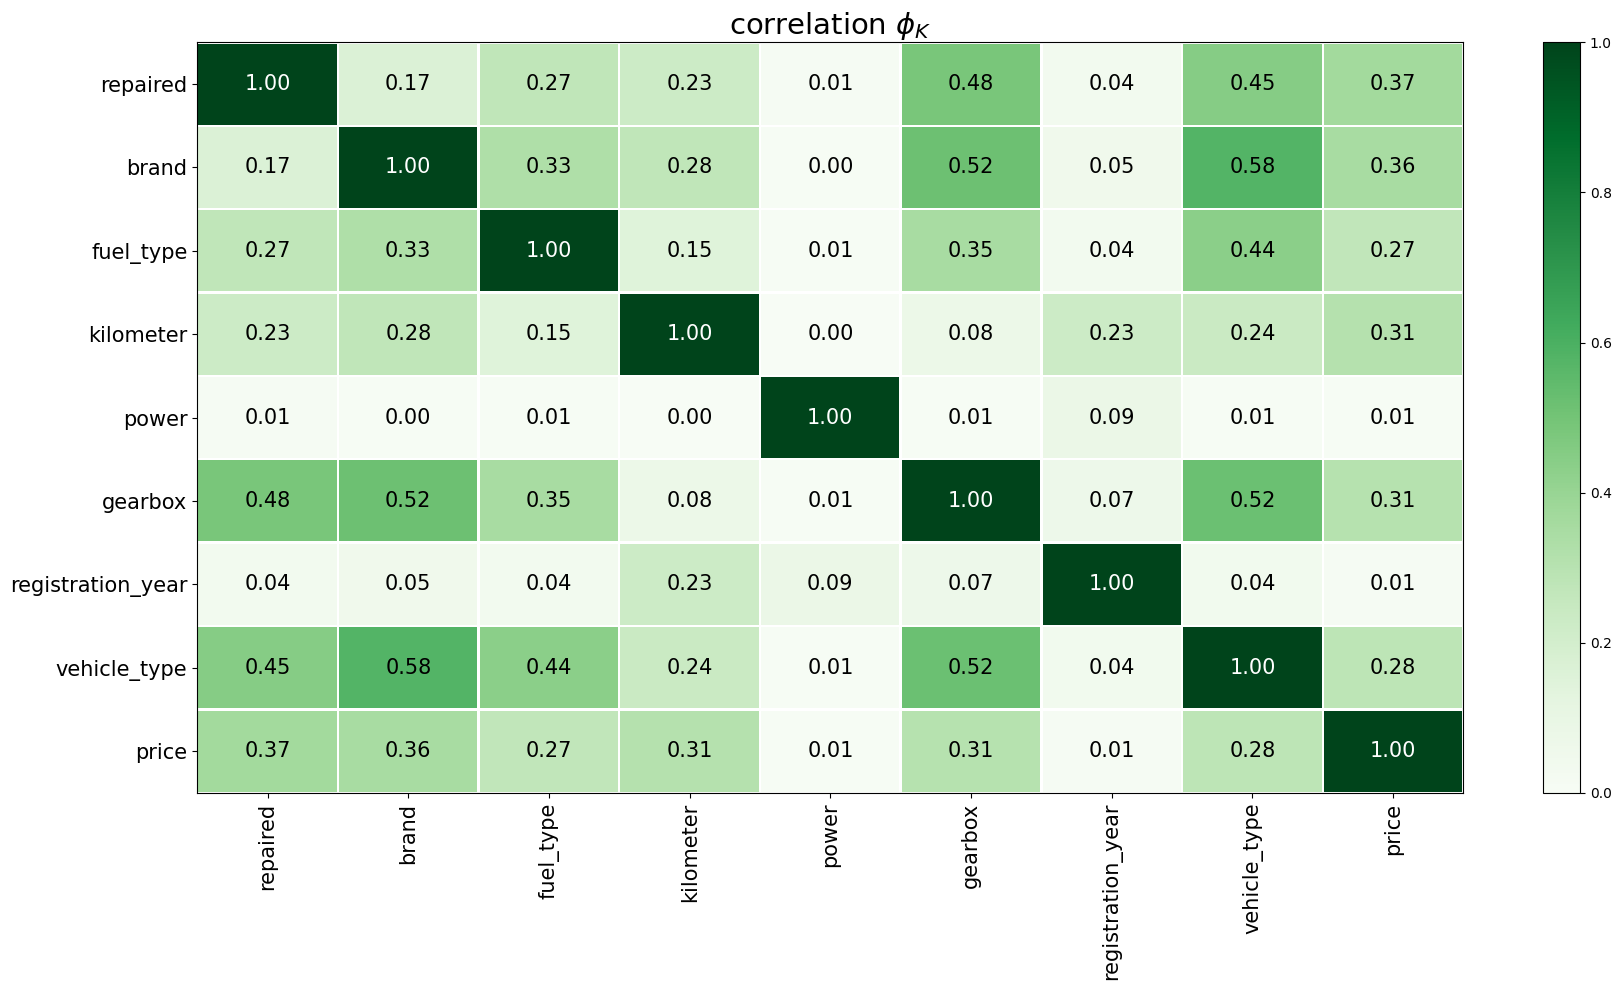

In [19]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(18, 10))
plt.tight_layout()

**Проверим, есть ли подозрительные и выбивающиеся данные в датасете `data`**. 

In [20]:
data.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Данная функция дает информацию о количественных признаках. Чтобы убрать выборсы по цене более эффективно - рассмотрим каждую переменную в отдельности графическим способом.

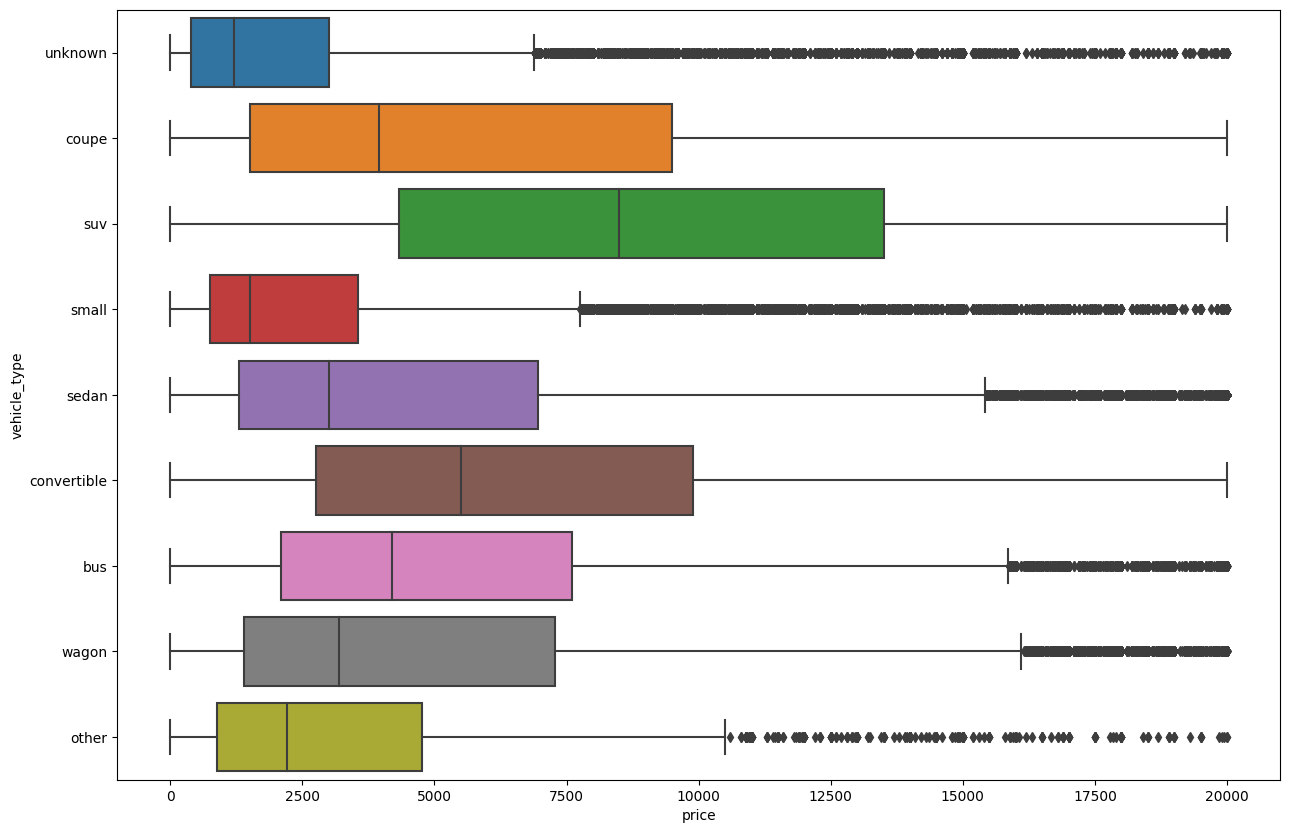

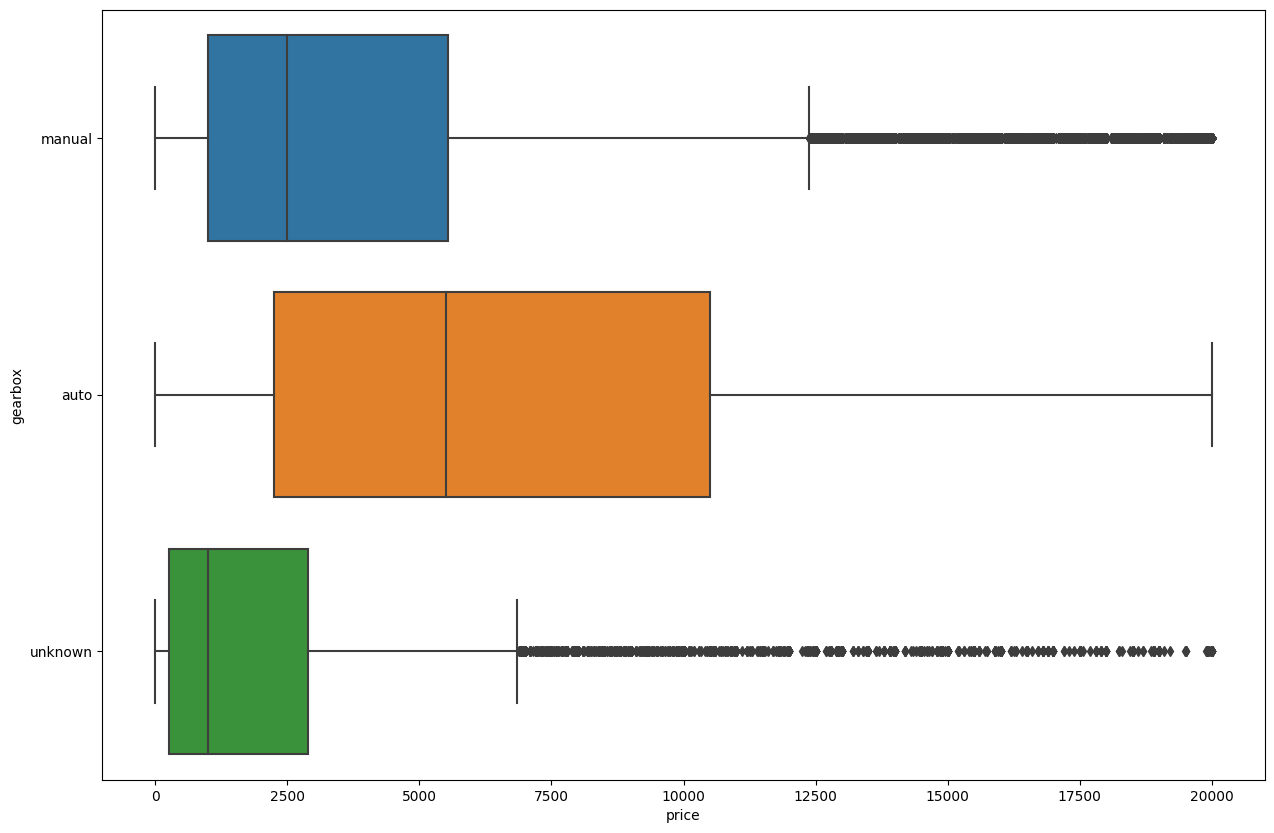

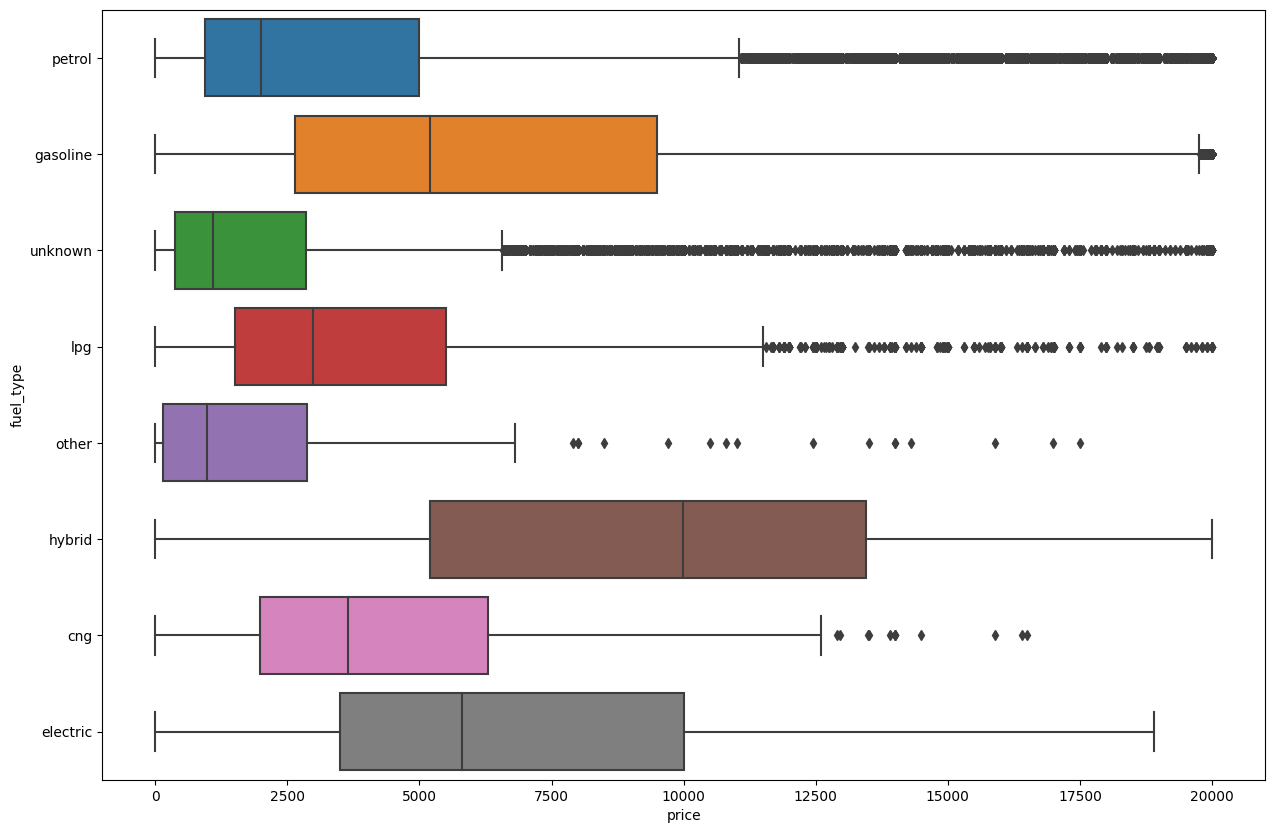

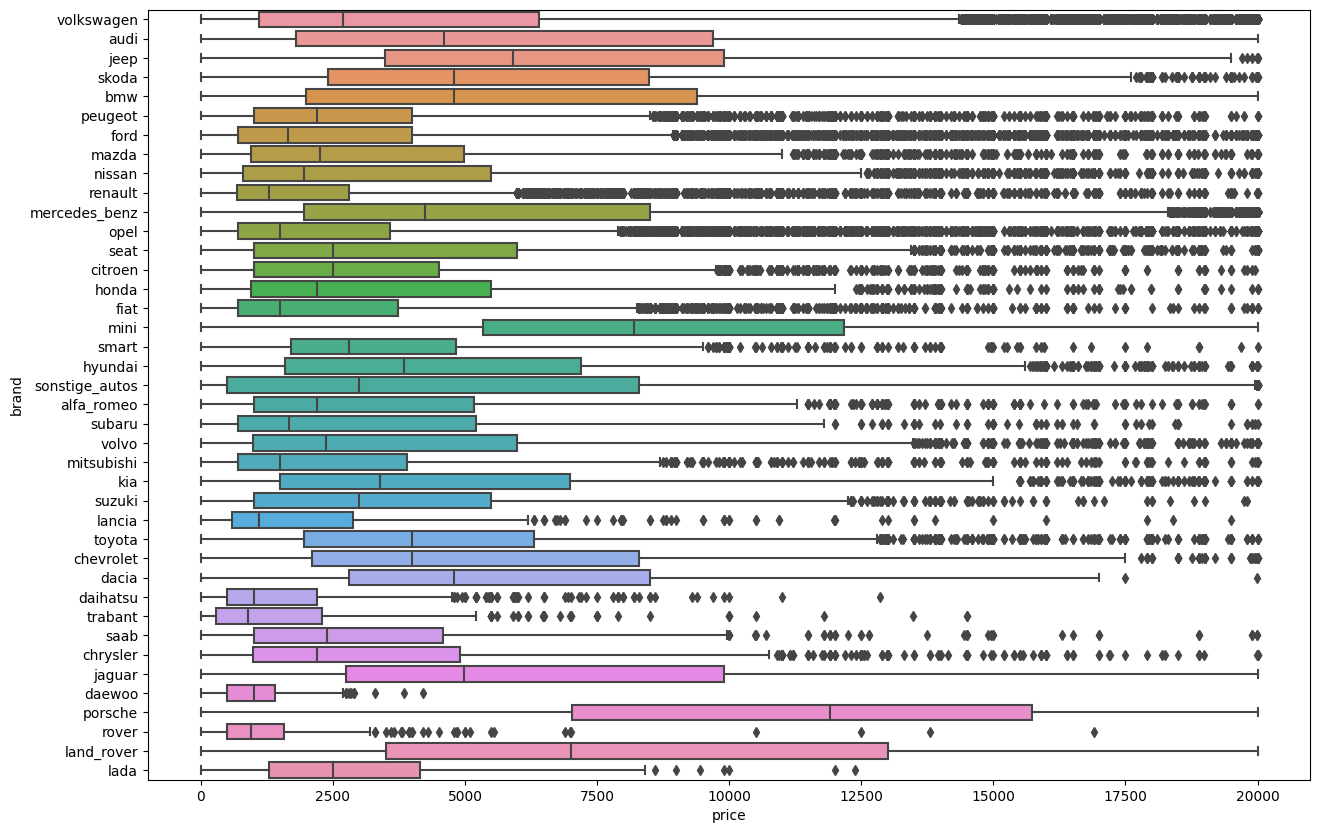

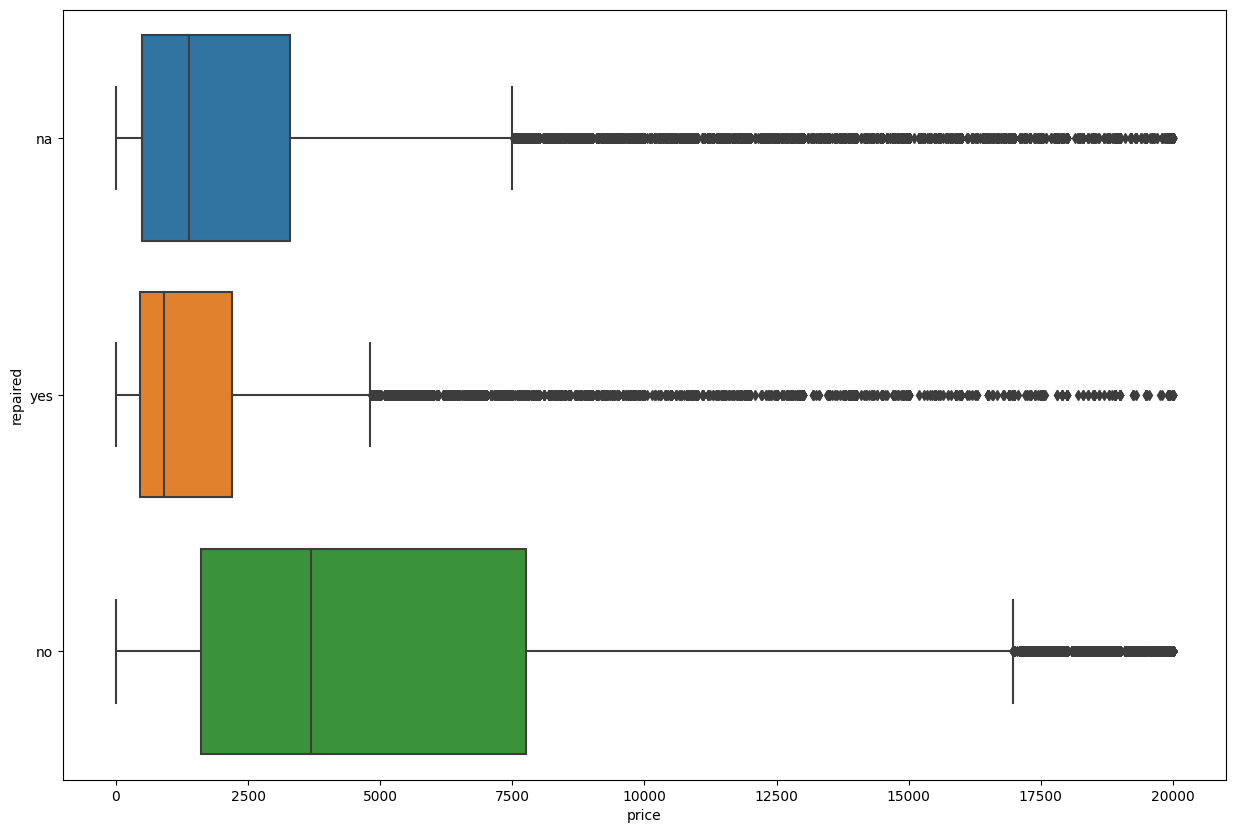

In [21]:
quantitative_columns = ['price', 'registration_year', 'power', 'kilometer']
categorical_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

#визуализация категориальных признаков
for column in categorical_columns:
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(15)
    sns.boxplot(y=column, x='price', data=data)

    plt.show()

По диаграммам размаха видно, что 
- по типу кузова наиболее популярными и дорогими по цене являются кроссоверы (suv), а наименее популярными малолитражки (small);
-  по типу коробки передач наиболее популярными и дорогими по цене являются автомобили с автоматической коробкой передач;
- по типу топлива наиболее дорогими по цене являются автомобили на гибридном топливе;
- по марке автомобиля наиболее дорогими по цене являются автомобили марки 'porsche';
- дороже продаются машины, которые не были в ремонте. 

Теперь проверим выбросы в количественных признаках.

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


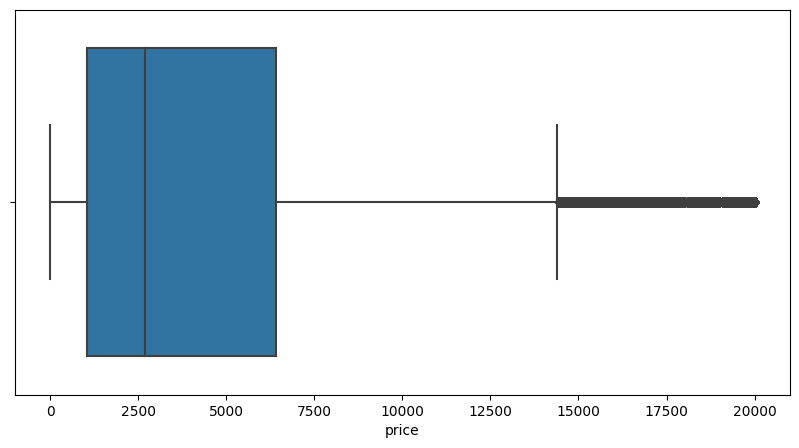

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


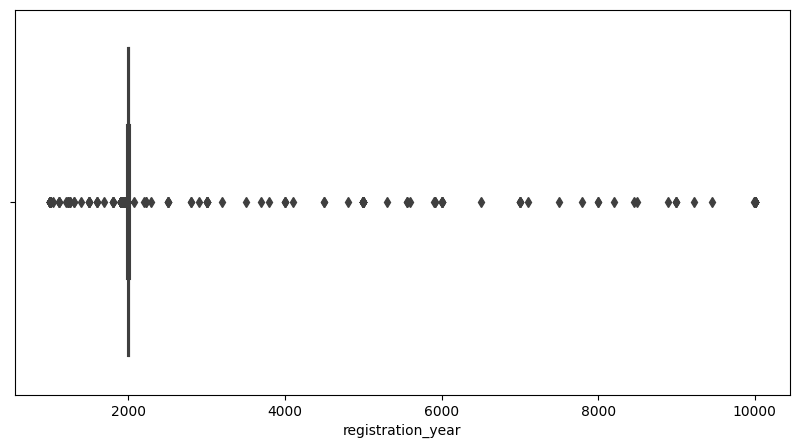

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


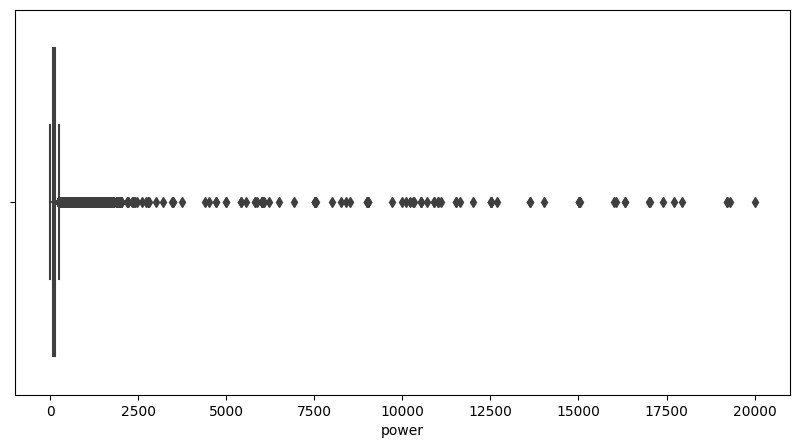

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


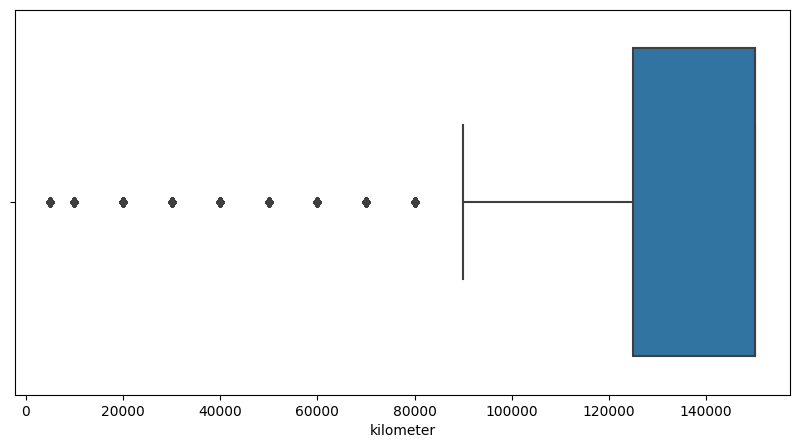

In [22]:
for column in quantitative_columns:
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    sns.boxplot(data[column])

    plt.show();

Удалим явные выбросы по году регистрации автомобиля, чтобы исключить редкие машины и ошибки в заполнении данных (ограничимся 2018 годом). 

In [23]:
data = data.query('registration_year > 1989 & registration_year < 2016')

Удалим явные выбросы по мощности автомобиля, чтобы исключить редкие машины. 

In [24]:
data = data.query('power < 600')

Рассмотрим целевой признак - цену! Удалим явные выбросы по цене автомобиля. 

In [25]:
data = data.query('price > 300')

Проверим количество дубликатов на новом датасете (после изменений).

In [26]:
print('Количество дубликатов в датасете data:', data.duplicated().sum())
print(f"Количество дубликатов в процентном соотношении {(data.duplicated().sum() / data.shape[0]) * 100} %.")

Количество дубликатов в датасете data: 45735
Количество дубликатов в процентном соотношении 15.32017097223711 %.


Удалим дубликаты и оставим только первое значение. 

In [27]:
data = data.drop_duplicates(keep='first')
print('Количество дубликатов в датасете data:', data.duplicated().sum())

Количество дубликатов в датасете data: 0


Количество строк отброшенных после обработки датасета (в процентах). 

In [28]:
print(round((100 - data.shape[0]/354369 * 100), 2), "%")

28.66 %


**Вывод:**
1. Исправили названния столбцов (привели к змеиному регистру).
2. Удалили из датасета дубликаты.
3. Обработали пропуски в датасете. 
4. Устранили явные выбросы.

[Оглавление](#intro).
<a id='task4'></a>

## Обучение моделей

Попробуем обучить модели LinearRegression, Lasso/Ridge, CatBoost и LightGBM и подобрать к ним гиперпараметры, чтобы сравнить время обучения, предсказания и метрику RMSE.

Все результаты сохраним в словаре.

In [29]:
total = {
    'rmse':[],
    'fit_time':[],
    'predict_time':[]
}

### Модель LinearRegression

Преобразуем категориальные признаки с помошью схемы кодирования OHE

In [30]:
data_ohe = pd.get_dummies(data, drop_first=True)

Разделим выборки на обучающую и валидационную. А также проведем масштабирование.

In [31]:
features = data_ohe.drop(['price'], axis=1)
target = data_ohe['price']
    
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                    test_size=0.25, random_state=1234)
 
print('Количество признаков в обучающей выборке', features_train.shape[0])
print('Количество признаков в тестовой выборке', features_valid.shape[0])
#применили метод масштабирования - стандартизация данных, 
#чтобы выровнять диапазон значений у количественных признаков
numeric_columns = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()

#масштабированные данные обучающей выборки
features_train[numeric_columns] = scaler.fit_transform(features_train[numeric_columns])
#масштабированные данные тестовой выборки
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
features_train.head()

Количество признаков в обучающей выборке 189594
Количество признаков в тестовой выборке 63199


,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
71086,0.730193,-1.836580,0.609926,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
196876,0.539500,-0.722505,-0.991723,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
108887,0.348807,-0.625629,0.609926,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
143299,-2.320899,-0.383438,0.609926,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
48968,0.730193,-0.851673,-1.525606,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0


Обучим модель с помощью кросс валидации и определим значение метрики RMSE.

In [32]:
%%time
start_time = time.time()

# построение модели
model_linreg = LinearRegression()
model_linreg.fit(features_train, target_train)

linreg_fit_time = time.time() - start_time
print("--- %.3f seconds ---" % (linreg_fit_time)) 

--- 0.561 seconds ---
CPU times: total: 1.05 s
Wall time: 561 ms


In [33]:
rmse_linreg = abs(np.mean(cross_val_score(model_linreg, features_train, 
                                        target_train, scoring='neg_root_mean_squared_error', 
                                        cv=5, n_jobs=-1)))

print('Итоговое значение метрики RMSE для LinearRegression:', round(rmse_linreg, 2))

Итоговое значение метрики RMSE для LinearRegression: 2463.56


In [34]:
%%time
start_time = time.time()

prediction_linreg = model_linreg.predict(features_valid)

linreg_pred_time = time.time() - start_time
print("--- %.3f seconds ---" % (linreg_pred_time)) 

--- 0.025 seconds ---
CPU times: total: 15.6 ms
Wall time: 24.9 ms


Занесем полученные данные в словарь.

In [35]:
total['rmse'].append(round(rmse_linreg, 2))
total['fit_time'].append(round((linreg_fit_time),3))
total['predict_time'].append(round((linreg_pred_time),3))
total

{'rmse': [2463.56], 'fit_time': [0.561], 'predict_time': [0.025]}

### Модель Lasso/Ridge

Обучим модели с регулиризацией L1 и L2.

**Lasso (L1 регуляризация)**

In [36]:
start_time = time.time()
alphas = np.arange(0, 1.5, 0.5)
for alpha in alphas :
    lasso = Lasso(alpha = alpha)
    rmse_lasso = abs(np.mean(cross_val_score(lasso, features_train, 
                                        target_train, cv=3, scoring='neg_root_mean_squared_error')))
    print(f'Итоговое значение метрики RMSE для Lasso: {round(rmse_lasso, 2)} при alpha ={alpha}') 
print("--- %.3f seconds ---" % (time.time() - start_time)) 

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.843e+11, tolerance: 2.692e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

Итоговое значение метрики RMSE для Lasso: 2463.8 при alpha =0.0
Итоговое значение метрики RMSE для Lasso: 2464.79 при alpha =0.5
Итоговое значение метрики RMSE для Lasso: 2466.85 при alpha =1.0
--- 28.242 seconds ---


Определим время построения модели, подсчета метрики на конкретной модели и время предсказания.

In [37]:
%%time
start_time = time.time()

# построение модели
model_lasso = Lasso(alpha = 0.1)
model_lasso.fit(features_train, target_train)

lasso_fit_time = time.time() - start_time
print("--- %.3f seconds ---" % (lasso_fit_time)) 

--- 5.854 seconds ---
CPU times: total: 22.9 s
Wall time: 5.85 s


In [38]:
rmse_lasso = abs(np.mean(cross_val_score(model_lasso, features_train, 
                                        target_train, cv=5, scoring='neg_root_mean_squared_error')))
print('Итоговое значение метрики RMSE для Lasso:', round(rmse_lasso, 2)) 

Итоговое значение метрики RMSE для Lasso: 2463.63


In [39]:
%%time
start_time = time.time()

prediction_lasso = model_lasso.predict(features_valid)

lasso_pred_time = time.time() - start_time
print("--- %.3f seconds ---" % (lasso_pred_time)) 

--- 0.020 seconds ---
CPU times: total: 62.5 ms
Wall time: 19.9 ms


Занесем полученные данные в словарь.

In [40]:
total['rmse'].append(round(rmse_lasso, 2))
total['fit_time'].append(round((lasso_fit_time),3))
total['predict_time'].append(round((lasso_pred_time),3))
total

{'rmse': [2463.56, 2463.63],
 'fit_time': [0.561, 5.854],
 'predict_time': [0.025, 0.02]}

**Ridge (L2 регуляризация)**

In [41]:
start_time = time.time()
alphas = np.arange(0, 1.5, 0.5)
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    rmse_ridge = abs(np.mean(cross_val_score(ridge, features_train, 
                                        target_train, cv=3, scoring='neg_root_mean_squared_error')))
    print(f'Итоговое значение метрики RMSE для Lasso: {round(rmse_ridge, 2)} при alpha ={alpha}') 
print("--- %.3f seconds ---" % (time.time() - start_time)) 

Итоговое значение метрики RMSE для Lasso: 2463.8 при alpha =0.0
Итоговое значение метрики RMSE для Lasso: 2463.8 при alpha =0.5
Итоговое значение метрики RMSE для Lasso: 2463.8 при alpha =1.0
--- 1.584 seconds ---


Определим время построения модели, подсчета метрики на конкретной модели и время предсказания.

In [42]:
%%time
start_time = time.time()

# построение модели
model_ridge = Ridge(alpha = 0.1)
model_ridge.fit(features_train, target_train)

ridge_fit_time = time.time() - start_time
print("--- %.3f seconds ---" % (ridge_fit_time)) 

--- 0.114 seconds ---
CPU times: total: 438 ms
Wall time: 114 ms


In [43]:
rmse_ridge = abs(np.mean(cross_val_score(ridge, features_train, 
                                        target_train, cv=5, scoring='neg_root_mean_squared_error')))
print('Итоговое значение метрики RMSE для Lasso:', round(rmse_ridge, 2)) 

Итоговое значение метрики RMSE для Lasso: 2463.56


In [44]:
%%time
start_time = time.time()

prediction_ridge = model_ridge.predict(features_valid)

ridge_pred_time = time.time() - start_time
print("--- %.3f seconds ---" % (ridge_pred_time)) 

--- 0.019 seconds ---
CPU times: total: 62.5 ms
Wall time: 18.9 ms


Занесем полученные данные в словарь.

In [45]:
total['rmse'].append(round(rmse_ridge, 2))
total['fit_time'].append(round((ridge_fit_time),3))
total['predict_time'].append(round((ridge_pred_time),3))
total

{'rmse': [2463.56, 2463.63, 2463.56],
 'fit_time': [0.561, 5.854, 0.114],
 'predict_time': [0.025, 0.02, 0.019]}

### Модель CatBoost

Выделим категориальные признаки отдельно и подготовим выборки для обучения. 

In [46]:
features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
    data.drop(['price'], axis=1), data['price'], test_size=0.25, random_state=12345)

С помощью RandomizedSearchCV подберем гиперпараметры. 

In [47]:
start_time = time.time()
params = {
    'learning_rate':[0.5],
    'depth': [3, 9, 12, 18] ,
    'l2_leaf_reg': [1, 3, 6, 9]  
}

grid_cat = RandomizedSearchCV(CatBoostRegressor(loss_function="RMSE", iterations=200, silent=True),
                    param_distributions=params,
                    cv=3,
                    scoring='neg_root_mean_squared_error',
                    verbose=False)

grid_cat.fit(features_train_boost, target_train_boost, cat_features=categorical_columns)
print("--- %.3f seconds ---" % (time.time() - start_time)) 

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\practicum\lib\site-packages\catboost\core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\User\anaconda3\envs\practicum\lib\site-packages\catboost\

--- 1145.897 seconds ---


Лучшие параметры для подсчета метрики

In [48]:
grid_cat.best_params_

{'learning_rate': 0.5, 'l2_leaf_reg': 9, 'depth': 9}

Обучим модель и посчитаем время.

In [49]:
%%time
start_time = time.time()

model_cat = CatBoostRegressor(loss_function="RMSE", iterations=200, min_data_in_leaf=50, 
                           learning_rate=0.5, depth=9, l2_leaf_reg=9, verbose=False)

model_cat.fit(features_train_boost, target_train_boost, cat_features=categorical_columns)

cat_fit_time = time.time() - start_time
print("--- %.3f seconds ---" % (cat_fit_time)) 

--- 101.264 seconds ---
CPU times: total: 2min 47s
Wall time: 1min 41s


Посчитам время предсказания и метрику rmse

In [50]:
%%time
start_time = time.time()
prediction_cat = model_cat.predict(features_test_boost)

cat_pred_time = time.time() - start_time
print("--- %.3f seconds ---" % (cat_pred_time)) 

rmse_cat = mean_squared_error(target_test_boost, prediction_cat) ** 0.5
print('Итоговое значение метрики RMSE для модели CatBoost:', round(rmse_cat, 2))

--- 0.394 seconds ---
Итоговое значение метрики RMSE для модели CatBoost: 1602.77
CPU times: total: 750 ms
Wall time: 395 ms


Занесем полученные данные в словарь.

In [51]:
total['rmse'].append(round(rmse_cat, 2))
total['fit_time'].append(round((cat_fit_time),3))
total['predict_time'].append(round((cat_pred_time),3))
total

{'rmse': [2463.56, 2463.63, 2463.56, 1602.77],
 'fit_time': [0.561, 5.854, 0.114, 101.264],
 'predict_time': [0.025, 0.02, 0.019, 0.394]}

### Модель LightGBM

Выделим категориальные признаки отдельно и подготовим выборки для обучения. 

In [52]:
features_train_boost[categorical_columns] = features_train_boost[categorical_columns].astype('category')
features_test_boost[categorical_columns] = features_test_boost[categorical_columns].astype('category')

С помощью RandomizedSearchCV подберем гиперпараметры. 

In [53]:
start_time = time.time()

params = {
    'learning_rate': [0.5],
    'max_depth': [3, 16, 3],
    'num_leaves': [0, 30, 10],
}

grid_lgbm = RandomizedSearchCV(LGBMRegressor(random_state=123, num_iterations=200),
                    param_distributions=params,
                    cv=3,
                    scoring='neg_root_mean_squared_error',
                    verbose=False)

grid_lgbm.fit(features_train_boost, target_train_boost, categorical_feature=categorical_columns)

print("--- %s seconds ---" % (time.time() - start_time)) 

C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\User\anaconda3\envs\practicum\lib\site-packages\lightgbm\basic.py:2065: User

--- 119.89977049827576 seconds ---


Лучшие параметры для подсчета метрики

In [54]:
grid_lgbm.best_params_

{'num_leaves': 30, 'max_depth': 16, 'learning_rate': 0.5}

Обучим модель и посчитаем время.

In [55]:
%%time
start_time = time.time()

model_lgbm = LGBMRegressor(random_state=123, num_iterations=200, min_data_in_leaf=50, 
                           learning_rate=0.5, max_depth=16, num_leaves=30, boost='gbdt')

model_lgbm.fit(features_train_boost, target_train_boost, categorical_feature=categorical_columns)

lgbm_fit_time = time.time() - start_time
print("--- %.3f seconds ---" % (lgbm_fit_time)) 

--- 8.394 seconds ---
CPU times: total: 6 s
Wall time: 8.39 s


Посчитам время предсказания и метрику rmse

In [56]:
%%time
start_time = time.time()

prediction_lgbm = model_lgbm.predict(features_test_boost)

lgbm_pred_time = time.time() - start_time
print("--- %.3f seconds ---" % (lgbm_pred_time)) 

rmse_lgbm = mean_squared_error(target_test_boost, prediction_lgbm) ** 0.5
print('Итоговое значение метрики RMSE для модели LightGBM:', round(rmse_lgbm, 2))

--- 0.368 seconds ---
Итоговое значение метрики RMSE для модели LightGBM: 1598.0
CPU times: total: 1.25 s
Wall time: 368 ms


Занесем полученные данные в словарь.

In [57]:
total['rmse'].append(round(rmse_lgbm, 2))
total['fit_time'].append(round((lgbm_fit_time),3))
total['predict_time'].append(round((lgbm_pred_time),3))
total

{'rmse': [2463.56, 2463.63, 2463.56, 1602.77, 1598.0],
 'fit_time': [0.561, 5.854, 0.114, 101.264, 8.394],
 'predict_time': [0.025, 0.02, 0.019, 0.394, 0.368]}

### Модель Constant

In [58]:
%%time
start_time = time.time()

prediction_const = np.ones(len(target_valid))* target_train.mean()

const_pred_time = time.time() - start_time
print("--- %.3f seconds ---" % (const_pred_time)) 

rmse_const = mean_squared_error(target_valid, prediction_const) ** 0.5
print('Итоговое значение метрики RMSE для модели Constant:', round(rmse_const, 2))

--- 0.000 seconds ---
Итоговое значение метрики RMSE для модели Constant: 4640.54
CPU times: total: 0 ns
Wall time: 0 ns


Занесем полученные данные в словарь.

In [59]:
total['rmse'].append(round(rmse_const, 2))
total['fit_time'].append(0)
total['predict_time'].append(round((const_pred_time),3))
total

{'rmse': [2463.56, 2463.63, 2463.56, 1602.77, 1598.0, 4640.54],
 'fit_time': [0.561, 5.854, 0.114, 101.264, 8.394, 0],
 'predict_time': [0.025, 0.02, 0.019, 0.394, 0.368, 0.0]}

**Вывод:**
1. Провели обучение моделей линейной регрессии без/с регуляризацией, а также модели градиентного бустинга LightGBM и CatBoost.
2. Измерили время обучения/предсказания моделей, а так же качество предсказаний по метрике RMSE.

[Оглавление](#intro).
<a id='task5'></a>

## Анализ моделей

In [60]:
pd.DataFrame(total, index=['LinearRegression', 'Lasso', 'Ridge', 'CatBoost', 'LGBM', 'Constant'])

,rmse,fit_time,predict_time
LinearRegression,2463.56,0.561,0.025
Lasso,2463.63,5.854,0.020
Ridge,2463.56,0.114,0.019
CatBoost,1602.77,101.264,0.394
LGBM,1598.00,8.394,0.368
Constant,4640.54,0.000,0.000


[Оглавление](#intro).
<a id='task6'></a>

## Общий вывод

1. Импортировали необходимые библиотеки.
2. Считали данные из csv-файла.
3. Вывели общую информацию по датафрейму: 
    - в датафрейме 16 столбцов и 354.369 строк;
    - присутствуют некорректно названные столбцы (не в змеином регистре);
    - в датасете присутствуют пропуски;
    - общая занимаемая память 43.3+ MB.
4. На этапе 'Предобработка данных': 
    - Исправили названния столбцов (привели к змеиному регистру).
    - Удалили из датасета дубликаты.
    - Удалили признаки `DateCrawled`, `DateCreated`, `NumberOfPictures`,`PostalCode`, `LastSeen`, `model`, так как в них нет необходимости при расчете моделей.
    - Обработали пропуски в датасете. 
    - Устранили явные выбросы в признаках 'registration_year', 'power', 'price'. 
    - Устранили дубликаты на новом датасете. 
5. Из таблицы в главе "Анализ моделей" видно, что модель линейной регрессии имеет такое же качество предсказаний, как и с регулеризацией. Модель с регулиризацией Ridge дает преимущество по времени в обучении. 
6. Модели градиентного бустинга 'CatBoost' и 'LGBM' дают заметное улучшение качества метрики, при этом могут обрабатывать и категориальные признаки тоже. 'CatBoost' уступает 'LGBM' по времени обучения, но имеет небольшое преимущество по времени предсказания. 